# Tarea Modulo 7.

Alumnos:

- Matías Obaid
- Millaray Ortega

Preguntas Clave a contestar:

1. ¿Existen productos favoritos que compran los clientes? 
2. ¿Existe algún horario específico en el que los clientes compran? 
3. ¿En qué horario sugeriría refuerzo en los servidores de la tienda para evitar un colapso? 
4. ¿Qué frecuencia de compra tiene un cliente de alta frecuencia? 
5. ¿Cuánto debería gastar un cliente para considerarlo sobre la media?
6. ¿Cómo se distribuyen las antigüedades de los clientes? 
7. Si se clasifican en 3 grupos a los clientes, en base a su frecuencia de compra ¿Qué diferencias existen entre cada grupo?

In [ ]:
#!pip install --upgrade matplotlib

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import plotly.express as px


## <font color="red" size="6">Carga de datos, limpieza, preprocesamiento</font>

In [ ]:
#a = pd.read_excel("/content/dataset_tarea_modulo_7.xlsx")
a = pd.read_csv("/content/OnlineRetail.csv", encoding="latin1")

In [ ]:
df = a.copy()

Cambiare el nombre de las columnas a español y a minisculas para mayor claridad y facilidad de trabajo

In [ ]:
df = df.rename(columns={"InvoiceNo": "numero_factura", "StockCode":"codigo_stock", "Description":"descripcion", "Quantity":"cantidad",
                   "InvoiceDate":"fecha_factura","UnitPrice":"precio_unitario","CustomerID": "id_cliente", "Country":"pais"})

In [ ]:
df.head()

,numero_factura,codigo_stock,descripcion,cantidad,fecha_factura,precio_unitario,id_cliente,pais
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Observamos que la data se encuentra en un nivel de [fact table](https://towardsdatascience.com/star-schema-924b995a9bdf). No se encuentra agrupado ni por Id del cliente, ni por numero de factura, ni por fecha de venta.. ni por ninguna otra columna... ya que el numero de filas (541.909) es muy superior al la cantidad de valores unicos que tiene cualquier columna.

Cada fila se entiende como el **registro** de compra de una cantidad especifica de un **producto** determinado por parte de un cliente en una determinada fecha.

In [ ]:
df.nunique()

numero_factura     25900
codigo_stock        4070
descripcion         4223
cantidad             722
fecha_factura      23260
precio_unitario     1630
id_cliente          4372
pais                  38
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   numero_factura   541909 non-null  object 
 1   codigo_stock     541909 non-null  object 
 2   descripcion      540455 non-null  object 
 3   cantidad         541909 non-null  int64  
 4   fecha_factura    541909 non-null  object 
 5   precio_unitario  541909 non-null  float64
 6   id_cliente       406829 non-null  float64
 7   pais             541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


id_cliente deberia ser un "string" o "object".

Llama la atencion que existan valores negativos de "cantidad", (quizas sean devoluciones de productos?), se ve que "cantidad" tiene valores bien extremos como minimos y maximos (curiosamente el mismo valor pero con signo cambiado).

tambien se ve que "precio_unitario" sufre problemas parecidos. (valores negativos y valores extremos).

No hace mucho sentido que existan precios_unitarios negativos, se entiende que existan "Cantidades" negativas debido a devoluciones, pero no precios. Veremos que sucede despues de la limpieza de filas que tienen valores faltantes.

In [ ]:
df.describe()

,cantidad,precio_unitario,id_cliente
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Observamos que hay 2 columnas que tienen Valores Faltantes, id_cliente con casi un 24.9% y descripcion con un 0.3% de valores faltantes.

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total_Faltante', 'Porcentaje_Faltante'])
missing_data["Porcentaje_Faltante"] = missing_data["Porcentaje_Faltante"].apply(lambda x: str(np.round(x,3)*100) + "%")
missing_data.head(20)

,Total_Faltante,Porcentaje_Faltante
id_cliente,135080,24.9%
descripcion,1454,0.3%
numero_factura,0,0.0%
codigo_stock,0,0.0%
cantidad,0,0.0%
fecha_factura,0,0.0%
precio_unitario,0,0.0%
pais,0,0.0%


No se logra dilucidar algún método para rellenar de forma correcta y coherente los valores faltantes de CustomerID, por lo que se procedera a eliminar las filas que tengan estos valores faltantes. Ya que entorpecerian analisis posteriores. (si bien hay algunas preguntas que puedo contestar antes de eliminar hacer esta eliminacion, ya que no necesitan de id_cliente, prefiero hacerlo ahora para evitar confucion)

Los pocos valores faltantes de la columna "descripcion" seran llenados con la imputacion "sin descripcion".

Se creara una nueva variable llamada "gasto_total", que sera la multiplicacion de "cantidad" y "precio_unitario".  (muy relevante tener esta columna para entender mas el dataset, constestar preguntas planteadas por los profesores y hacer segmentacion).

En Resumen.

- Se Rellenaran valores faltante de la columna descripcion con "sin descripcion")
- Se eliminaran  todas filas que tengan valores faltantes/nulos de id_cliente.
- Se pasara fecha de factura "fecha_factura" a Datatype de fecha de Pandas (Datetime64ns) .<br>
- Se transformara el datatype de id_cliente a "string" o objeto.<br>
- Se creara el nuevo feature "gasto_total". (multiplicacion entre cantidad y precio_unitario)

In [ ]:
df["descripcion"] = df["descripcion"].fillna('sin descripcion')
df = df.dropna()
df["fecha_factura"] = pd.to_datetime(df["fecha_factura"])
df["id_cliente"]= df["id_cliente"].astype("str")
df["gasto_total"] = df["cantidad"] * df["precio_unitario"]

Observamos que ya no hay datos faltantes.

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total_Faltante', 'Porcentaje_Faltante'])
missing_data["Porcentaje_Faltante"] = missing_data["Porcentaje_Faltante"].apply(lambda x: str(np.round(x,3)*100) + "%")
missing_data.head(20)

,Total_Faltante,Porcentaje_Faltante
numero_factura,0,0.0%
codigo_stock,0,0.0%
descripcion,0,0.0%
cantidad,0,0.0%
fecha_factura,0,0.0%
precio_unitario,0,0.0%
id_cliente,0,0.0%
pais,0,0.0%
gasto_total,0,0.0%


Aqui observamos que al eliminar las filas que tenian valores faltantes de id_cliente, se soluciono el problema de tener valores de "precio_unitario" negativos,

sin embargo se sigue observando que precio_unitario tiene un minimo de 0, (esto si puede ser factible si la tienda esta dando regalos).

In [ ]:
df.describe()

,cantidad,precio_unitario,gasto_total
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,20.401854
std,248.693370,69.315162,427.591718
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.200000
50%,5.000000,1.950000,11.100000
75%,12.000000,3.750000,19.500000
max,80995.000000,38970.000000,168469.600000


Vemos que existen 5225 filas duplicadas.

Tiene sentido que existan filas duplicadas? o es un error que no deberia estar?.

Si el mismo cliente, comprara 2 veces el mismo producto, en la misma fecha, la variable que cambiaria seria "cantidad" en lugar de crearse una fila nueva en el dataset. Siguiendo esta logica considero que las filas duplicadas son un error y hay que eliminarlas.

In [ ]:
df.duplicated().sum()

5225

In [ ]:
df = df.drop_duplicates(keep="first")
df.duplicated().sum()

0

**Solucionando el problema de regalos y devoluciones**

Se eliminaran las filas que se consideren devoluciones o regalos.

- Devoluciones se entenderan como todas aquellas tengan "cantidad" < 0.

- Regalos se entenderan como todos aquellos que tenga "cantidad" > 0 y "precio_unitario" == 0.

El caso extremo de cantidad==0, no existe (se reviso).

In [ ]:
df[df["cantidad"]==0].shape[0]

0

In [ ]:
# Dataset sin regalos
regalos = df[(df["cantidad"]>0) & (df["precio_unitario"]==0)].index
df_sin_regalos_pero_con_devoluciones = df.drop(regalos)  # Voy a conservar este dataset para mas tarde.
df = df.drop(regalos)

# Dataset sin devoluciones ni regalos
devoluciones = df[df["cantidad"]<0].index
df = df.drop(devoluciones)

In [ ]:
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   numero_factura   392692 non-null  object        
 1   codigo_stock     392692 non-null  object        
 2   descripcion      392692 non-null  object        
 3   cantidad         392692 non-null  int64         
 4   fecha_factura    392692 non-null  datetime64[ns]
 5   precio_unitario  392692 non-null  float64       
 6   id_cliente       392692 non-null  object        
 7   pais             392692 non-null  object        
 8   gasto_total      392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.0+ MB


Se realizaran Histogramas de las variables Continuas a modo de analisis inicial.

Se Observan histogramas muy distorcionados. Esto se atribuye a los valores extremos superiores (outliers) en la distribucion de  estos features.


Para poder tener histrogramas mas visualizables y informativos, realizaremos un formateo condicional recogiendo a partir del quantile 95 hacia abajo de estas 3 variables continuas. (para evitar distorcion causada por valores extremos)

Se observa que estas 3 distribuciones se encuentran sesgadas hacia la derecha (media > mediana > moda). (skewed right).

In [ ]:
sns.set_style("darkgrid")

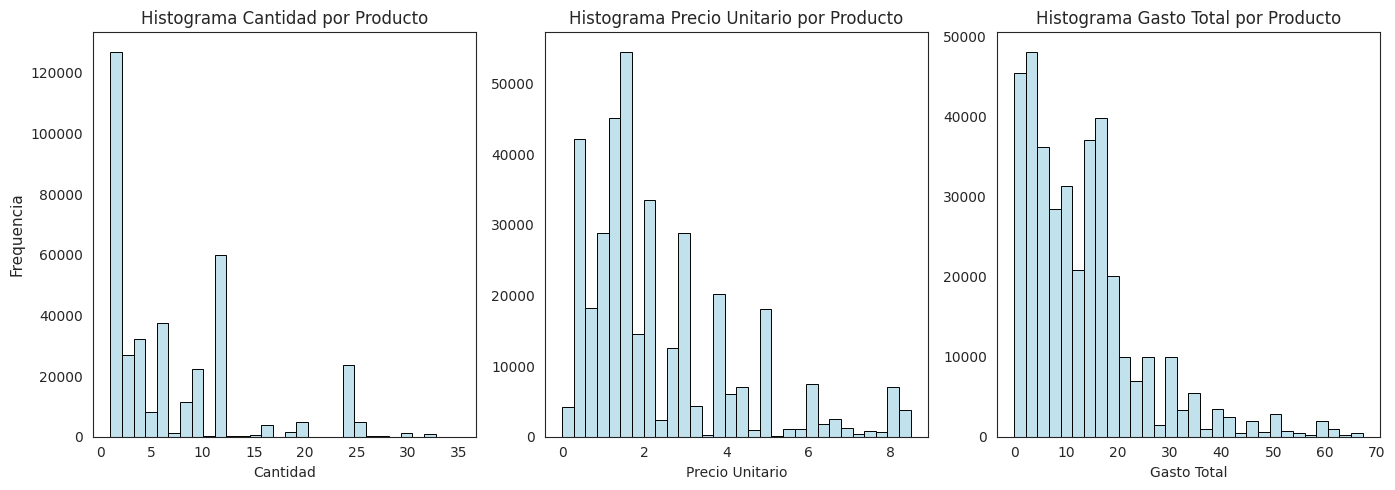

In [ ]:
x = df.select_dtypes("number")

plt.figure(figsize=(14,5),dpi=100)
for i , n in enumerate(x.columns.to_list()):

    z = x[x[n] < x[n].quantile(0.95)][n]
    plt.subplot(1,3,i+1)
    ax = sns.histplot(x=z, kde=False, bins=30, color="lightblue", edgecolor="black" )#, multiple="stack")
    #plt.title(f"Histograma {n}", fontdict={"fontsize":13})
    #plt.xlabel("")
    plt.ylabel("Frequencia", fontdict={"fontsize":11})
    plt.xticks(rotation=0)
    if i not in [0]:
        plt.ylabel("")

    if i == 0:
      plt.title("Histograma de Cantidad por Producto")
      plt.xlabel("Cantidad")

    if i == 1:
      plt.title("Histograma de Precio Unitario por Producto")
      plt.xlabel("Precio Unitario")
    
    if i == 2:
      plt.title("Histograma de Gasto Total por Producto")
      plt.xlabel("Gasto Total")
    
plt.tight_layout();

<font color="red" size=6>1. ¿Existen productos favoritos que compran los clientes?</font>

Si, los productos con mas apariciones en facturas distintas son descritos en el siguiente barplot.

el top 3 por ejemplo seria.

- White Hanging Heart T-Light Holder
- Regency Cakestand 3 Tier
- Jumbo Bag Red Retrospot

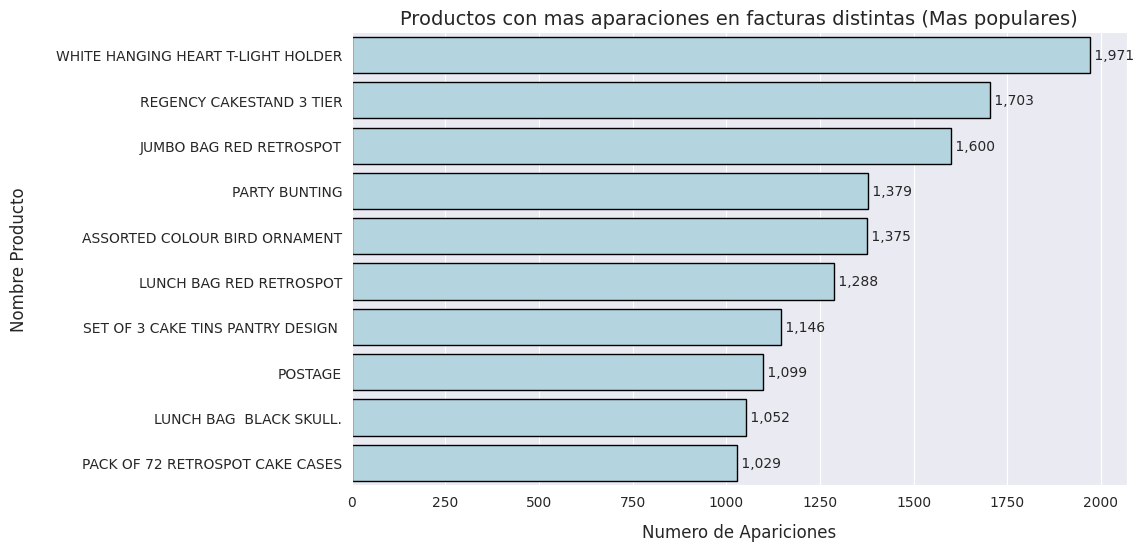

In [ ]:
# Productos con mas apariciones en facturas unicas.

productos_duplicados_misma_factura = df[df[["descripcion","numero_factura"]].duplicated()].index

z = df.drop(productos_duplicados_misma_factura)["descripcion"].value_counts().head(10)

plt.figure(figsize=(10,6),dpi=100)
ax = sns.barplot(x=z.values,y=z.index,orient="h", color="#52ddd4", edgecolor="black");
plt.title("Productos con mas aparaciones en facturas distintas (Mas populares)", fontsize=14);
plt.xlabel("Numero de Apariciones", fontsize=12, labelpad=10)
plt.ylabel("Nombre Producto", fontsize=12, labelpad=20);

#ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

for c in ax.containers:
        labels = [" "+f"{round(v.get_width(),0):,.0f}" for v in c]
        ax.bar_label(c, labels=labels, label_type='edge');

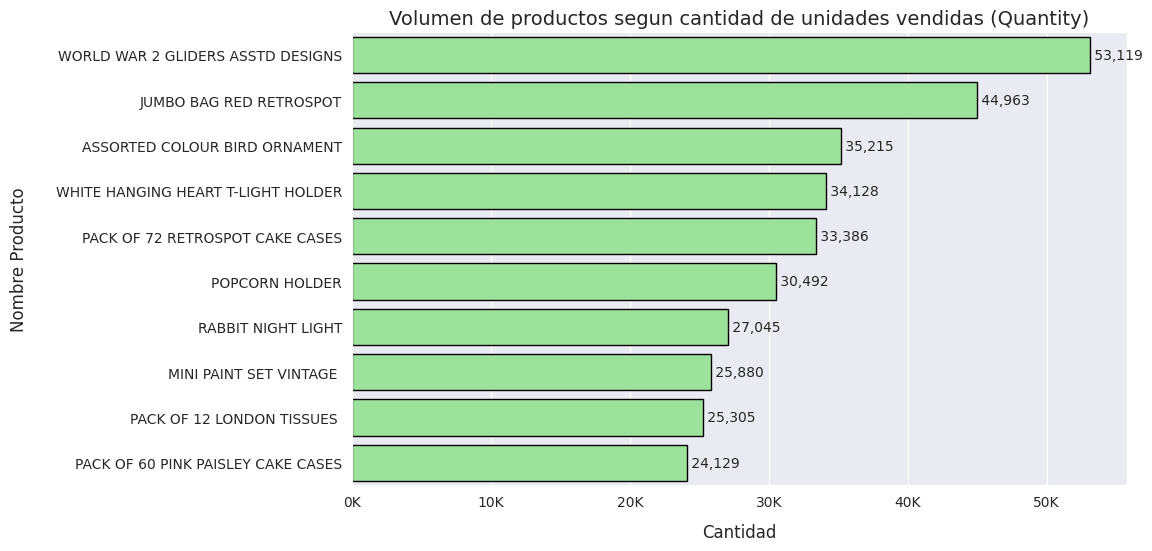

In [ ]:
# Volumen de productos segun cantidad de unidades vendidas. (Devoluciones fueron incluidas, pero no se incluyen regalos)

# el dataframe df_sin_regalos_pero_con_devoluciones, se definio cuando se hacia la limpieza y el preprocesamiento.
z = df_sin_regalos_pero_con_devoluciones.groupby("descripcion").sum().sort_values(by="cantidad", ascending=False).head(10)["cantidad"]

plt.figure(figsize=(10,6),dpi=100)
ax = sns.barplot(x=z.values,y=z.index,orient="h", color="lightgreen", edgecolor="black");
plt.title("Volumen de productos segun cantidad de unidades vendidas (Quantity)", fontsize=14);
plt.xlabel("Cantidad", fontsize=12, labelpad=10)
plt.ylabel("Nombre Producto", fontsize=12, labelpad=20);

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

for c in ax.containers:
        labels = [" "+f"{round(v.get_width(),0):,.0f}" for v in c]
        ax.bar_label(c, labels=labels, label_type='edge');


<font color="red" size=6>2. ¿Existe algún horario específico en el que los clientes compran?</font>

Los clientes tienen favoritismo para comprar los dias Miercoles y jueves, especialmente a las 12:00 y 13:00 horas

Tambien existe una mayor frequencia de facturacion afines de año.

<font color="red" size=6>3. ¿En qué horario sugeriría refuerzo en los servidores de la tienda para evitar un colapso? </font>

la mayor actividad se registra apartir de 10 hasta las 15 horas, con peaks maximos en las 12:00 y 13:00 horas. Por lo que este seria nuestro horario de sugerencia a reforzar.

Tambien se deberian reforzar los servidores con mira a los meses finales del año. (no sabemos si esto es por un comportamiento ciclico del negocio, ya que tenemos un solo año de data, o si es que el negocio anda bien y esta teniendo cada vez mas movimiento).



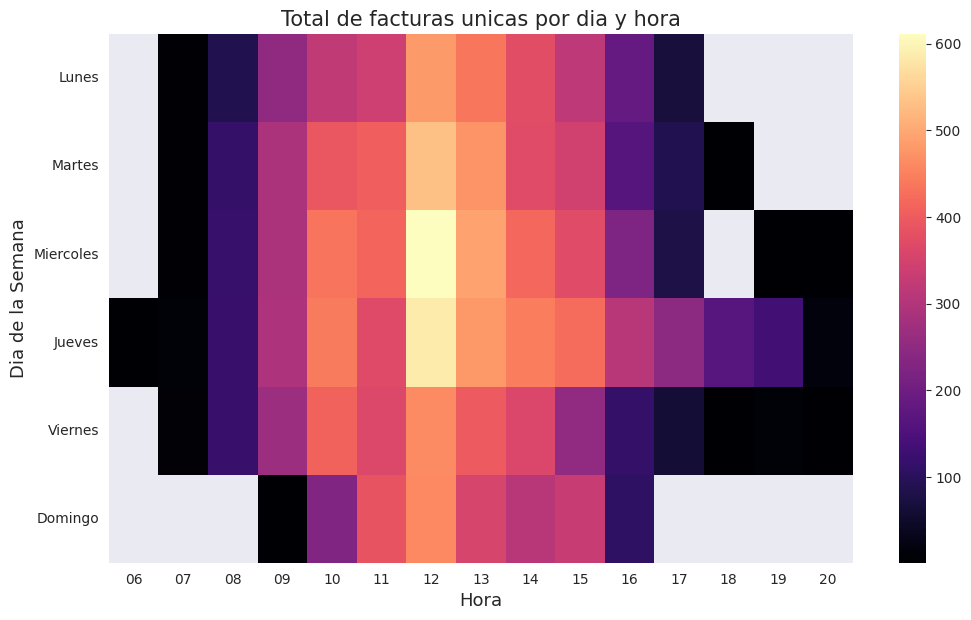

In [ ]:
df['hora'] = df['fecha_factura'].apply(lambda x: x.strftime('%H'))
df['dia_de_la_semana'] = df['fecha_factura'].apply(lambda x: x.day_name())

z  = df.groupby(["dia_de_la_semana","hora"])["numero_factura"].nunique().reset_index()

z= z.pivot_table(index='dia_de_la_semana', columns='hora', values = 'numero_factura', aggfunc="sum")
z = z.reindex(index = ["Monday","Tuesday","Wednesday","Thursday", "Friday", "Sunday"])
z = z.rename(index=dict(zip(["Monday","Tuesday","Wednesday","Thursday", "Friday", "Sunday"],["Lunes","Martes","Miercoles","Jueves", "Viernes", "Domingo"])))

plt.figure(figsize=(12,7),dpi=100)
sns.heatmap(z, cmap="magma")
plt.ylabel("Dia de la Semana", fontsize=13)
plt.xlabel("Hora", fontsize=13)
plt.title("Total de facturas unicas por dia y hora", fontsize=15);
plt.yticks(rotation=0); 

In [ ]:
#Observamos que las horas donde mas se han existido facturas unicas en total (no en promedio) son a las 12:00 y 13:00. seguido despues por 11:00 y 14:00.

z  = df.groupby(["dia_de_la_semana","hora"])["numero_factura"].nunique().reset_index()
np.round(z.groupby("hora").sum().rename(columns={"numero_factura":"Total Facturas Unicas"}).transpose(),0)

hora,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
Total Facturas Unicas,1,29,555,1393,2226,2277,3130,2636,2274,2037,1100,544,169,144,18


In [ ]:
#Los Dias en facturacion total (no en promedio)  han sido son los jueves y miercoles, el dia donde menos facturas unicas se han echo es el domingo

np.round(z.groupby("dia_de_la_semana").sum().reindex(index = ["Monday","Tuesday","Wednesday","Thursday", "Friday", "Sunday"]
                                            ).rename(columns={"numero_factura":"Total Facturas Unicas"}).transpose(),0)

dia_de_la_semana,Monday,Tuesday,Wednesday,Thursday,Friday,Sunday
Total Facturas Unicas,2863,3184,3455,4033,2829,2169


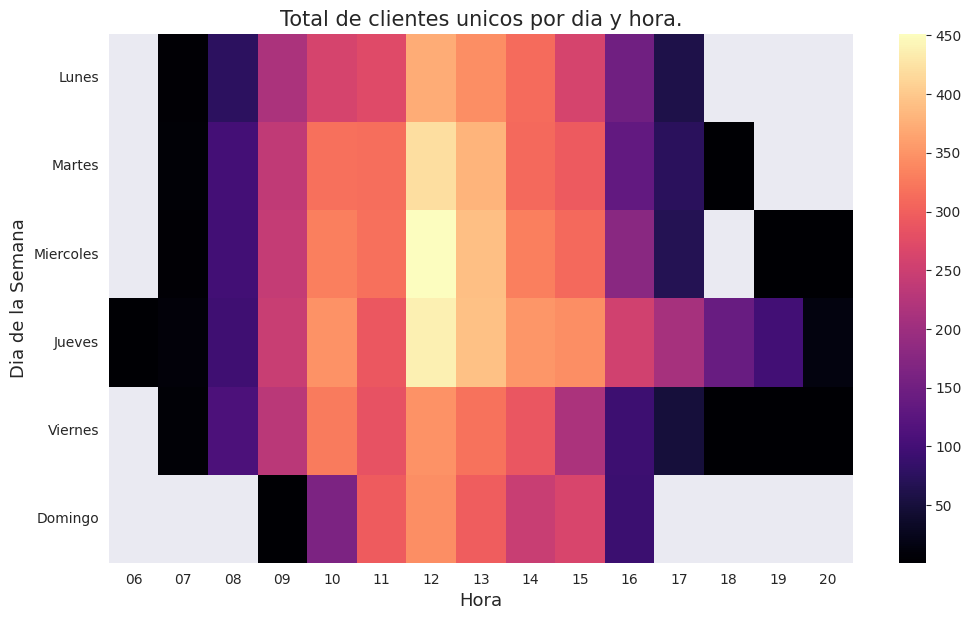

In [ ]:
z = df.groupby(["dia_de_la_semana","hora"])["id_cliente"].nunique().reset_index()
z= z.pivot_table(index='dia_de_la_semana', columns='hora', values = 'id_cliente', aggfunc="sum")
z = z.reindex(index = ["Monday","Tuesday","Wednesday","Thursday", "Friday", "Sunday"])
z = z.rename(index=dict(zip(["Monday","Tuesday","Wednesday","Thursday", "Friday", "Sunday"],["Lunes","Martes","Miercoles","Jueves", "Viernes", "Domingo"])))

plt.figure(figsize=(12,7),dpi=100)

sns.heatmap(z, cmap="magma")
plt.ylabel("Dia de la Semana", fontsize=13)
plt.xlabel("Hora", fontsize=13)
plt.title("Total de clientes unicos por dia y hora.", fontsize=15);
plt.yticks(rotation=0); 

In [ ]:
#Observamos que las horas donde en total (no en promedio) hay mas clientes unicos son a las 12:00 y 13:00. seguido despues por 11:00 y 14:00.

z  = df.groupby(["dia_de_la_semana","hora"])["id_cliente"].nunique().reset_index()
np.round(z.groupby("hora").sum().rename(columns={"id_cliente":"Total Clientes Unicos"}).transpose(),0)

hora,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
Total Clientes Unicos,1,28,480,1171,1747,1773,2374,2122,1839,1685,901,460,143,100,16


In [ ]:
#Observamos que los dias donde en total (no en promedio) hay mas clientes unicos son los jueves y miercoles, el dia mas inactivo es el domingo.

np.round(z.groupby("dia_de_la_semana").sum().reindex(index = ["Monday","Tuesday","Wednesday","Thursday", "Friday", "Sunday"]
                                                     ).rename(columns={"id_cliente":"Total Clientes unicos"}).transpose(),0)

dia_de_la_semana,Monday,Tuesday,Wednesday,Thursday,Friday,Sunday
Total Clientes unicos,2327,2585,2717,3232,2275,1704


Observando este grafico de frequencia de facturacion por semana, Se recomienda tener reforzados los servidores hacia final de año. Ya que se observa que ahi hay mayor frequencia de facturacion.

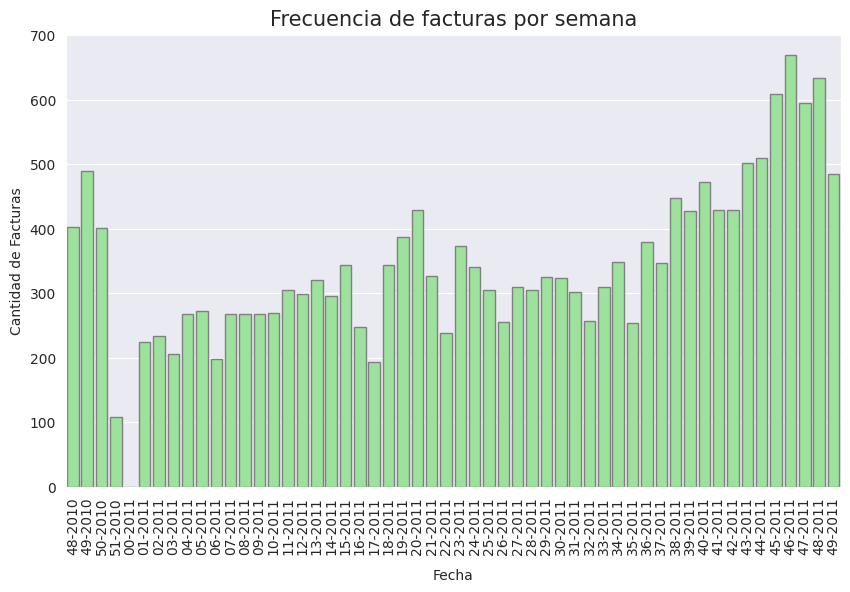

In [ ]:
datas = df.groupby("numero_factura", as_index=False).first().set_index("fecha_factura").resample("W").count()["numero_factura"]

plt.figure(figsize=(10,6),dpi=100)
sns.barplot(x=datas.index.strftime('%W-%Y'),y=datas.values, color="lightgreen", edgecolor="gray")
plt.title("Frecuencia de facturas por semana", fontsize=15)
plt.ylabel("Cantidad de Facturas")
plt.xticks(rotation=90);
plt.xlabel(xlabel="Fecha", labelpad=10);

<font color="red" size="6">4. ¿Qué frecuencia de compra tiene un cliente de alta frecuencia? </font>

Muy alta frequencia, mayor a 11.
Alta frequencia mayor a 5.


**<font color="green" size="5.5"> Se Creara un df agrupado por clientes y generare features importantes relacionados a estos para poder responder a esta pregunta y hacer analisis posteriores</font>**


In [ ]:
df_agrupado_por_clientes = pd.DataFrame(df.groupby('id_cliente')['fecha_factura'].max()).reset_index()
df_agrupado_por_clientes['recencia']=(df['fecha_factura'].max()- df_agrupado_por_clientes['fecha_factura']).dt.days
df_agrupado_por_clientes.rename(columns={"fecha_factura": "ultima_fecha_de_facturacion"}, inplace=True)
df_agrupado_por_clientes['frequencia'] = df.groupby(["id_cliente"])["numero_factura"].nunique().reset_index()["numero_factura"]

primera_fecha_de_facturacion_cliente = pd.DataFrame(df.groupby('id_cliente')['fecha_factura'].min()).reset_index()["fecha_factura"]
df_agrupado_por_clientes['primera_fecha_de_facturacion'] = primera_fecha_de_facturacion_cliente

max = df["fecha_factura"].max()
antiguedad = max - df_agrupado_por_clientes['primera_fecha_de_facturacion']

df_agrupado_por_clientes['antiguedad'] = antiguedad.dt.days

# Agrego pais del cliente. # si el cliente por algun motivo tiene mas de algun pais, se elige la moda como su default.
b = df.groupby("id_cliente")["pais"].agg(pd.Series.mode).reset_index()
df_agrupado_por_clientes = pd.merge(left=df_agrupado_por_clientes, right=b, on="id_cliente")


# Voy a agregar la columna de gasto_total de los clientes. sin embargo usare el dataframe que tiene incluidas las devoluciones para esto.
# Ya que engañosamente algunos clientes podrian aparecer como muy relevantes pero en verdad devolvieron lo que compraron.
# Estos clientes seran eliminados si el gasto_total de estos es menor o igual a 0.

x = df_sin_regalos_pero_con_devoluciones.groupby("id_cliente").sum()["gasto_total"].reset_index()
df_agrupado_por_clientes = pd.merge(left=df_agrupado_por_clientes, right=x, on="id_cliente")

df_agrupado_por_clientes = df_agrupado_por_clientes[df_agrupado_por_clientes["gasto_total"]>0]

#Reordeno columnas para que quede bonito.
df_agrupado_por_clientes = df_agrupado_por_clientes[["id_cliente", "primera_fecha_de_facturacion", "ultima_fecha_de_facturacion", "pais",
                                                     "recencia", "frequencia","antiguedad","gasto_total"]]
df_agrupado_por_clientes

,id_cliente,primera_fecha_de_facturacion,ultima_fecha_de_facturacion,pais,recencia,frequencia,antiguedad,gasto_total
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,Iceland,1,7,366,4310.00
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,Finland,74,4,357,1797.24
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,Italy,18,1,18,1757.55
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway,309,1,309,334.40
5,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,Norway,35,8,296,1545.41
...,...,...,...,...,...,...,...,...
4333,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,United Kingdom,277,1,277,180.60
4334,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,United Kingdom,180,1,180,80.82
4335,18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00,United Kingdom,7,2,125,176.60
4336,18283.0,2011-01-06 14:14:00,2011-12-06 12:02:00,United Kingdom,3,16,336,2045.53


El termino "alta frequencia" es un poco arbitrario.

Para responder a esta pregunta, Consideraremos a clientes de "muy alta frequencia", a aquellos que esten por encima del "whisker superior" del Boxplot a continuacion, es decir a todos los que tienen una frequencia mayor a Q3 + (1.5*IQR) = 11.

Estos clientes aparecen como Outliers en el boxplot.

Podriamos tambien considerar "alta frequencia", a los clientes que tienen una frequencia mayor a Q3 es decir mayor a 5.

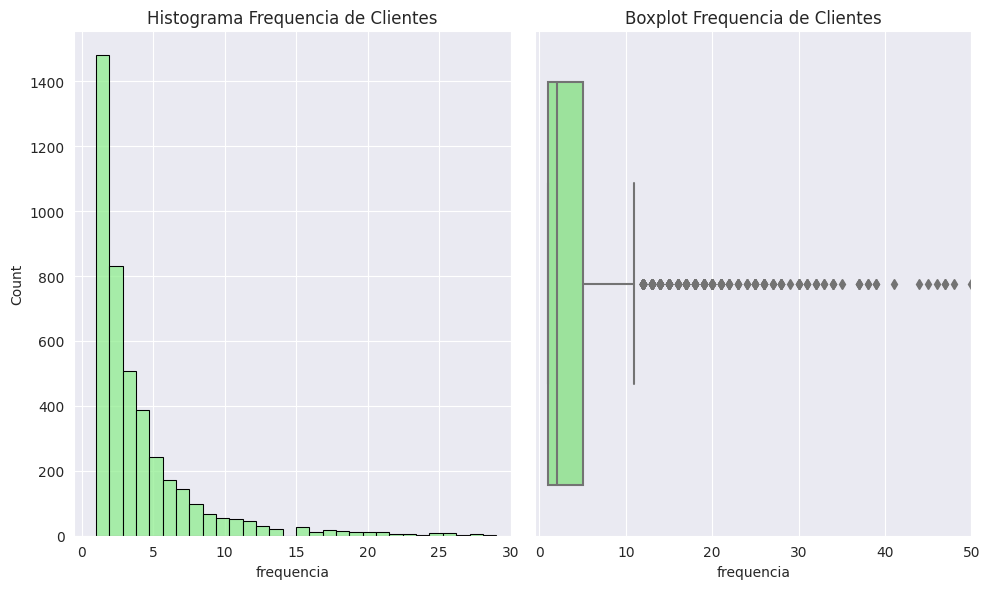

In [ ]:
plt.figure(figsize=(10,6),dpi=100)
plt.subplot(1,2,1)
sns.histplot(x=df_agrupado_por_clientes[df_agrupado_por_clientes["frequencia"] < 30]["frequencia"] ,color="lightgreen", edgecolor="black",bins=30)
plt.title("Histograma Frequencia de Clientes")
plt.xlim([-0.5,30])

plt.subplot(1,2,2)
sns.boxplot(x=df_agrupado_por_clientes["frequencia"], color="lightgreen")
plt.title("Boxplot Frequencia de Clientes");
plt.ylabel("")
plt.xlim([-0.5,50])
plt.tight_layout();

In [ ]:
Q3 = df_agrupado_por_clientes["frequencia"].quantile(0.75)
Q1 = df_agrupado_por_clientes["frequencia"].quantile(0.25)
IQR = Q3 - Q1

Q3 + (1.5*IQR), Q3

(11.0, 5.0)

<font color="red" size="6">5. ¿Cuánto debería gastar un cliente para considerarlo sobre la media?</font>

En promedio un cliente para considerarse sobre la media deberia haber gastado en total sobre 1.918 libras, para considerarse sobre la mediana deberia gastar mas de 653 libras.

Observamos que el gasto total por cliente tiene una distribucion sesgada hacia la derecha (Skewed to the right, "Positive Skew"),  Media > Mediana > Moda.

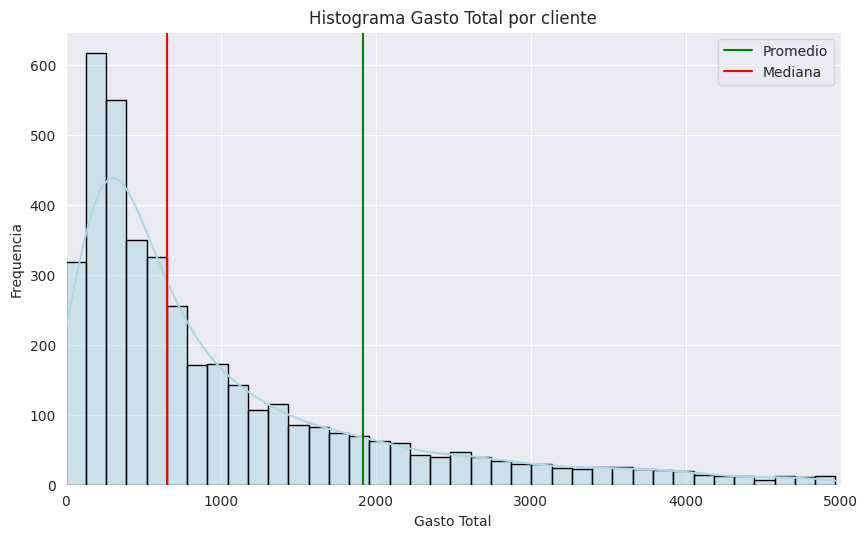

In [ ]:
sns.set_style("darkgrid")

plt.figure(figsize=(10,6),dpi=100)
sns.histplot(x=df_agrupado_por_clientes[df_agrupado_por_clientes["gasto_total"] < 5000]["gasto_total"], color="lightblue", edgecolor="black", kde=True);
plt.xlim([0,5000]);
plt.axvline(x=1918, ymin=0, ymax=800, label="Promedio", color="green");
plt.axvline(x=653, ymin=0, ymax=800, label="Mediana", color="red");
plt.xlabel("Gasto Total")
plt.ylabel("Frequencia")
plt.title("Histograma Gasto Total por cliente")
plt.legend();

In [ ]:
np.round(df_agrupado_por_clientes["gasto_total"].mean(),0) , np.round(df_agrupado_por_clientes["gasto_total"].median(),0)


(1918.0, 653.0)

<font color="red" size="6">6. ¿Cómo se distribuyen las antigüedades de los clientes?</font>

Se observa que hay una gran base de clientes que tiene una antiguedad de alrededor de un año. (evento y marketing de inaguracion?), apartir de ahi, las frequencias de las antiguedades desciende drasticamente, pero se observa que posterior a la caida inical (mirando el histograma de derecha a izquierda), la frequencia de antiguedad mas o menos se estabiliza, esto implica que el negocio sigue siendo capaz de atraer a clientes nuevos a medida que pasa el tiempo (antiguedades bajas).

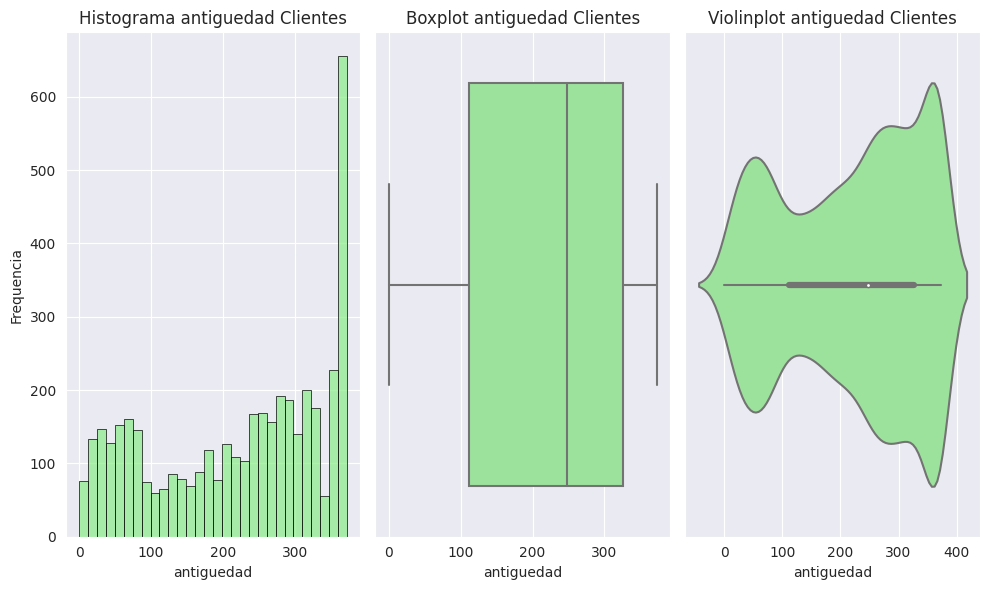

In [ ]:
plt.figure(figsize=(10,6),dpi=100)
plt.subplot(1,3,1)
sns.histplot(x=df_agrupado_por_clientes["antiguedad"], color="lightgreen", edgecolor="black",bins=30);
plt.title("Histograma antiguedad Clientes")
plt.ylabel("Frequencia")

plt.subplot(1,3,2)
sns.boxplot(x=df_agrupado_por_clientes["antiguedad"], color="lightgreen");
plt.title("Boxplot antiguedad Clientes")
plt.tight_layout();

plt.subplot(1,3,3)
sns.violinplot(x=df_agrupado_por_clientes["antiguedad"], color="lightgreen");
plt.title("Violinplot antiguedad Clientes")
plt.tight_layout();

<font color="red" size="6">7. Si se clasifican en 3 grupos a los clientes, en base a su frecuencia de compra ¿Qué diferencias existen entre cada grupo?</font>

In [ ]:
pipeline_kmeans = Pipeline([
    ("norm", StandardScaler()),
    ("kmeans", KMeans(n_clusters = 3)),
])

In [ ]:
df_kmeans = df_agrupado_por_clientes.set_index("id_cliente")[["recencia","frequencia","gasto_total"]]

In [ ]:
clusters = pipeline_kmeans.fit_predict(df_kmeans)

In [ ]:
df_kmeans["kmeans_clusters"] = clusters
df_kmeans["kmeans_clusters"] = df_kmeans["kmeans_clusters"].astype("str")

In [ ]:
fig = px.scatter_3d(df_kmeans, x= "frequencia", y="recencia", z="gasto_total",
                    color = "kmeans_clusters", color_discrete_sequence=["green","blue","red"], symbol="kmeans_clusters",
                                     labels={
                     "frequencia": "Frequencia",
                     "recencia": "Recencia",
                     "gasto_total": "Gasto Total"
                 },
                title="3d Scatterplot Kmeans Clusters")

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))



Analisis de CLusters.

Kmeans Clustering se ejecuto considerando 3 variables.
Recencia, Frequencia y gasto_total.

<font color="red">Cluster 2</font>: Son nuestros Clientes de elite, muy pocos en numero (23), el promedio del gasto total de estos es altisimo, han comprado muchas veces en nuestro sitio web, y la ultima vez que realizaron una compra en este fue hace muy poco. Estas 23 personas representan el 22.42% del gasto total en la tienda, Es de vital importancia mantener la fidelidad de estos clientes y prestarles una atencion "premium" de ser posible, para asegurarnos que continuen con nosotros.

<font color="green">Cluster 1</font>: Son nuestros clientes "normales", son la base del negocio, son muchos en numero (3217) y representan el 71.23% de los gasto totales realizados en compras en la tienda, en promedio han frequentado la tienda mas de 4 veces y su ultima visita a la tienda fue en promedio hace 40 dias (recencia).

<font color="blue">Cluster 0</font>: Son Nuestos clientes "malos"  y/o perdidos, en promedio no han frequentado la tienda mas de 2 veces, son varios en cantidad (1082), pero representan solo el 6.35% de el gasto total en la tienda, la ultima vez que visitaron la tienda en promedio fue hace mucho.

In [ ]:
clusters_df_analis = df_kmeans.groupby("kmeans_clusters").mean()
clusters_df_analis["cantidad_de_clientes"] = df_kmeans.groupby("kmeans_clusters").count()["recencia"]
clusters_df_analis =  clusters_df_analis.rename(columns={"recencia":"recencia promedio", "frequencia":"frequencia promedio"})
clusters_df_analis = clusters_df_analis.rename(columns={"gasto_total":"gasto promedio"})
clusters_df_analis["gasto total"] = df_kmeans.groupby("kmeans_clusters").sum()["gasto_total"]
clusters_df_analis["% de gasto total"] = np.round(clusters_df_analis["gasto total"] / clusters_df_analis["gasto total"].sum() * 100,2)
clusters_df_analis["% de gasto total"] = clusters_df_analis["% de gasto total"].astype("str") + "%"
clusters_df_analis

,recencia promedio,frequencia promedio,gasto promedio,cantidad_de_clientes,gasto total,% de gasto total
kmeans_clusters,,,,,,
0,245.088725,1.585028,486.677201,1082,526584.731,6.35%
1,40.088903,4.698788,1835.977592,3217,5906339.913,71.23%
2,5.304348,73.130435,80818.431304,23,1858823.920,22.42%


<font color="red"> Grafico extra a eleccion</font>

Se observa que por lejos, el reino unido es el pais de mayor relevancia, por si solo represanta alreadedor del 80% de los gasto totales por parte de clientes en la tienda.

In [ ]:
paret = pd.DataFrame(df_agrupado_por_clientes.groupby("pais").sum()["gasto_total"].sort_values(ascending=False))
paret["cumulative_percent"] = paret.gasto_total.cumsum()/paret.gasto_total.sum()*100

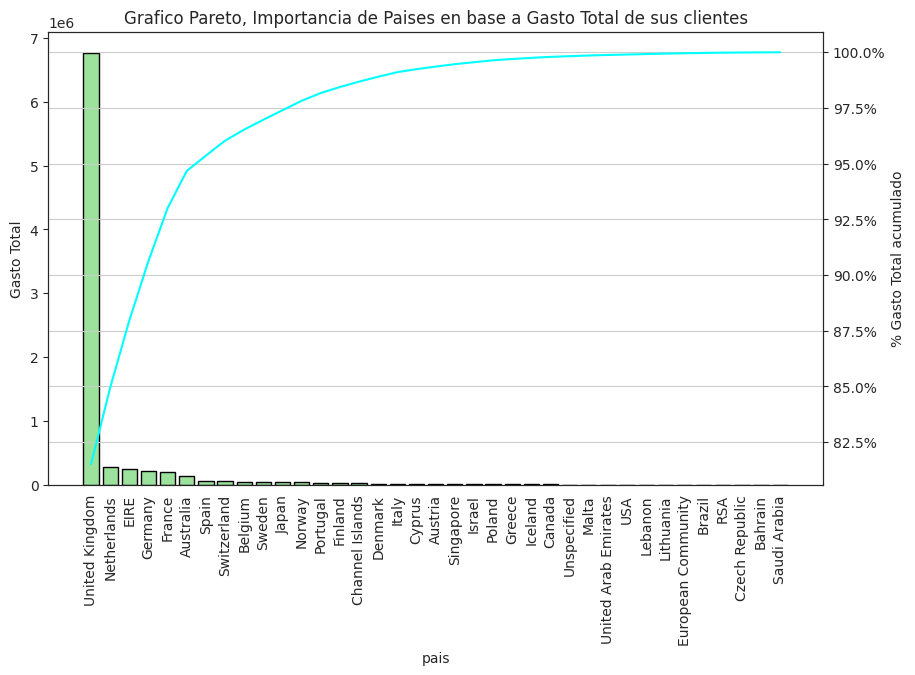

In [ ]:
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(10,6),dpi=100)
ax1 = sns.barplot(y=paret.gasto_total,x=paret.index, color="lightgreen", edgecolor="black")
plt.ylabel("Gasto Total")
plt.grid(visible=False);
ax2 = ax1.twinx()
sns.lineplot(y=paret.cumulative_percent, x=paret.index, color="cyan",ax=ax2)
ax1.tick_params(axis="x",rotation=90)
plt.grid(visible=True);
plt.title("Grafico Pareto, Importancia de Paises en base a Gasto Total de sus clientes")
plt.ylabel("% Gasto Total acumulado");
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())